## MODELOS DE Feed Forward NN PARA DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO


Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
csv_demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


Vamos a graficar los datos "originales" de demanda eléctrico desde 2005 hasta 2022

Text(0, 0.5, 'Demanda [MMpcd]')

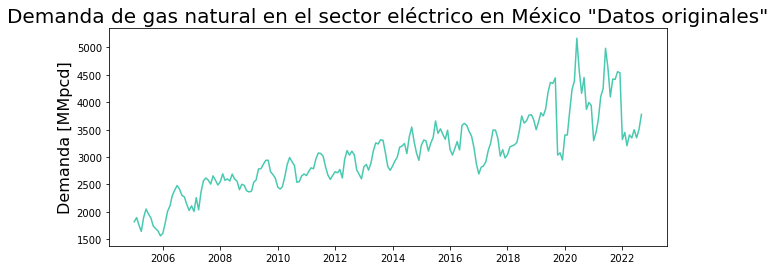

In [27]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Vamos a descomponer la serie de tiempo de datos "originales" de demanda eléctrico desde 2005 hasta 2022 en sus compoentes de Tendencia, Estacionalidad y Residual 

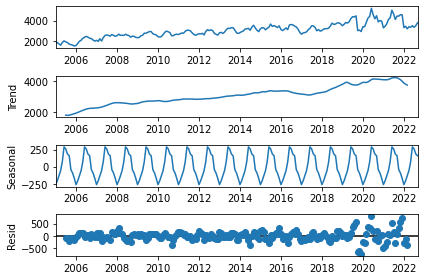

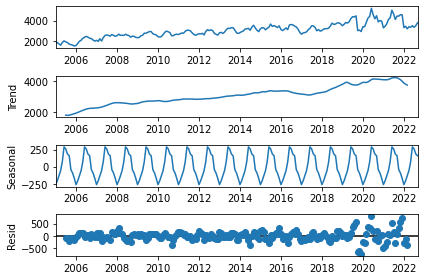

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_electrico_original_seasonal_decomposition = seasonal_decompose(csv_demanda_electrico_original)
csv_demanda_electrico_original_seasonal_decomposition.plot()

Separamos la Demanda de gas natural en el sector eléctrico en data de train y test

In [29]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
csv_demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
csv_demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

csv_demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [30]:
from keras.preprocessing.sequence import TimeseriesGenerator

Se aplica el TimeseriesGnerator para producir sets de n_inputs + 1 output para el caso de

In [31]:
n_input = 24

# Assuming you have a column in your DataFrame named 'demand_data' that contains your time series data
data = csv_demanda_electrico_original_train_data['Demanded_Gas'].values
targets = data  # You can adjust this if your target data is different

demanda_electrico_NOscaled_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


Se presentan los primeros n_inputs elementos en csv_demanda_electrico_original_train_data 

In [32]:
demanda_electrico_NOscaled_train_generator[0]

(array([[1819.58, 1895.33, 1765.86, 1642.7 , 1895.54, 2051.72, 1962.05,
         1889.66, 1739.1 , 1695.92, 1648.95, 1560.98, 1610.45, 1806.33,
         2006.88, 2108.31, 2298.9 , 2398.88, 2480.62, 2413.08, 2298.49,
         2273.91, 2134.41, 2025.98]]),
 array([2108.85]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [33]:
print("Total number of samples in the original training data = ", len(csv_demanda_electrico_original_train_data)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_NOscaled_train_generator))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


Se importan las librerias necesarias para definir la red Neuronal de tipo Feed Forward Sequential Neural Network

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU. 

La primer cada Dense constará de N, nodos y n_input inputs.
Por lo que el número de parámetros a estimar para esta primer capa sería 
Parámetros_n_capa_densa = n_input *  #Nodos + # Nodos
Donde  n_input *  #Nodos: Representa la matriz de pesos 
Y # Nodos: el vector de bias  


In [35]:
n_input = 24
n_features = 1

# define model
model_sequential_and_FF = Sequential()
model_sequential_and_FF.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_sequential_and_FF.add(Dense(32, activation='relu'))
model_sequential_and_FF.add(Dense(1))
model_sequential_and_FF.compile(optimizer='Adam', loss='mse')

In [13]:
model_sequential_and_FF.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36, 64)            128       
                                                                 
 dense_1 (Dense)             (None, 36, 32)            2080      
                                                                 
 dense_2 (Dense)             (None, 36, 1)             33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [36]:
model_sequential_and_FF.fit(demanda_electrico_NOscaled_train_generator, epochs=25)

Epoch 1/25


177/177 [==============================] - 1s 2ms/step - loss: 1065485.5000
Epoch 2/25
177/177 [==============================] - 0s 2ms/step - loss: 185943.7188
Epoch 3/25
177/177 [==============================] - 0s 2ms/step - loss: 186010.6719
Epoch 4/25
177/177 [==============================] - 0s 2ms/step - loss: 182160.3906
Epoch 5/25
177/177 [==============================] - 0s 2ms/step - loss: 187884.4531
Epoch 6/25
177/177 [==============================] - 0s 2ms/step - loss: 191987.5938
Epoch 7/25
177/177 [==============================] - 0s 2ms/step - loss: 189773.6719
Epoch 8/25
177/177 [==============================] - 0s 2ms/step - loss: 189331.0938
Epoch 9/25
177/177 [==============================] - 0s 2ms/step - loss: 183330.9375
Epoch 10/25
177/177 [==============================] - 0s 2ms/step - loss: 189085.7188
Epoch 11/25
177/177 [==============================] - 0s 2ms/step - loss: 187101.1562
Epoch 12/25
177/177 [==============================] - 0s 2ms/

Se grafica la perdida por epoch 

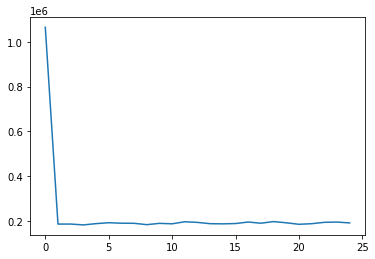

In [37]:
loss_per_epoch = model_sequential_and_FF.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [38]:

demanda_electrico_NOscaled_train_batch = csv_demanda_electrico_original_train_data['Demanded_Gas'].values[-n_input:]


demanda_electrico_NOscaled_train_batch

array([3037.44, 3076.62, 2947.09, 3402.47, 3402.47, 3819.3 , 4235.25,
       4387.91, 5168.27, 4581.99, 4163.77, 4451.61, 3869.77, 3996.14,
       3941.12, 3298.43, 3454.21, 3681.3 , 4104.82, 4243.93, 4985.53,
       4631.85, 4098.81, 4424.39])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [39]:
demanda_electrico_NOscaled_train_batch_reshaped = demanda_electrico_NOscaled_train_batch.reshape(1,n_input, n_features)
demanda_electrico_NOscaled_train_batch_reshaped

array([[[3037.44],
        [3076.62],
        [2947.09],
        [3402.47],
        [3402.47],
        [3819.3 ],
        [4235.25],
        [4387.91],
        [5168.27],
        [4581.99],
        [4163.77],
        [4451.61],
        [3869.77],
        [3996.14],
        [3941.12],
        [3298.43],
        [3454.21],
        [3681.3 ],
        [4104.82],
        [4243.93],
        [4985.53],
        [4631.85],
        [4098.81],
        [4424.39]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [40]:
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)

1/1 [==============================] - 0s 159ms/step


array([[[3220.3477],
        [3261.8464],
        [3124.6506],
        [3606.9812],
        [3606.9812],
        [4048.4805],
        [4489.048 ],
        [4650.7427],
        [5477.2866],
        [4856.309 ],
        [4413.3374],
        [4718.212 ],
        [4101.9375],
        [4235.786 ],
        [4177.5107],
        [3496.7837],
        [3661.7832],
        [3902.3132],
        [4350.898 ],
        [4498.2417],
        [5283.731 ],
        [4909.12  ],
        [4344.5327],
        [4689.382 ]]], dtype=float32)

Y se observa el valor predicho ESCALADO para la demanda de gas en el primer mes o dato de prueba como función de los n datos anteriores y dado el modelo model_sequential_and_FF

In [41]:
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][-1][0]

1/1 [==============================] - 0s 26ms/step


4689.382

In [22]:
model_sequential_and_FF.predict([[
        [3772.25],
        [3676.41],
        [3500.08],
        [3647.6 ],
        [3807.71],
        [3750.5 ],
        [3876.48],
        [4184.76],
        [4361.97],
        [4343.61],
        [4445.27],
        [3037.44],
        [3076.62],
        [2947.09],
        [3402.47],
        [3402.47],
        [3819.3 ],
        [4235.25],
        [4387.91],
        [5168.27],
        [4581.99],
        [4163.77],
        [4451.61],
        [3869.77],
        [3996.14],
        [3941.12],
        [3298.43],
        [3454.21],
        [3681.3 ],
        [4104.82],
        [4243.93],
        [4985.53],
        [4631.85],
        [4098.81],
        [4424.39], [model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][-1][0]]]])

1/1 [==============================] - 0s 91ms/step


array([[[3986.1543],
        [3884.949 ],
        [3698.7483],
        [3854.5264],
        [4023.5994],
        [3963.1873],
        [4096.219 ],
        [4421.7563],
        [4608.887 ],
        [4589.4985],
        [4696.85  ],
        [3210.21  ],
        [3251.5835],
        [3114.8022],
        [3595.6743],
        [3595.6743],
        [4035.8386],
        [4475.073 ],
        [4636.279 ],
        [5460.3237],
        [4841.2236],
        [4399.592 ],
        [4703.5444],
        [4089.1335],
        [4222.5776],
        [4164.478 ],
        [3485.81  ],
        [3650.3108],
        [3890.1128],
        [4337.3413],
        [4484.2393],
        [5267.353 ],
        [4893.875 ],
        [4330.9956],
        [4674.8013],
        [4939.23  ]]], dtype=float32)

In [23]:
model_sequential_and_FF.predict([[
        [3676.41],
        [3500.08],
        [3647.6 ],
        [3807.71],
        [3750.5 ],
        [3876.48],
        [4184.76],
        [4361.97],
        [4343.61],
        [4445.27],
        [3037.44],
        [3076.62],
        [2947.09],
        [3402.47],
        [3402.47],
        [3819.3 ],
        [4235.25],
        [4387.91],
        [5168.27],
        [4581.99],
        [4163.77],
        [4451.61],
        [3869.77],
        [3996.14],
        [3941.12],
        [3298.43],
        [3454.21],
        [3681.3 ],
        [4104.82],
        [4243.93],
        [4985.53],
        [4631.85],
        [4098.81],
        [4424.39],    [4939.23  ]]])

1/1 [==============================] - 0s 259ms/step


array([[[3884.949 ],
        [3698.7483],
        [3854.5264],
        [4023.5994],
        [3963.1873],
        [4096.219 ],
        [4421.7563],
        [4608.887 ],
        [4589.4985],
        [4696.85  ],
        [3210.21  ],
        [3251.5835],
        [3114.8022],
        [3595.6743],
        [3595.6743],
        [4035.8386],
        [4475.073 ],
        [4636.279 ],
        [5460.3237],
        [4841.2236],
        [4399.592 ],
        [4703.5444],
        [4089.1335],
        [4222.5776],
        [4164.478 ],
        [3485.81  ],
        [3650.3108],
        [3890.1128],
        [4337.3413],
        [4484.2393],
        [5267.353 ],
        [4893.875 ],
        [4330.9956],
        [4674.8013],
        [5218.461 ]]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input (a partir de los ultimos valores en la data de entrenamiento) para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [42]:
n_input = 24
n_features = 1

In [43]:
test_predictions_model_sequential_and_FF = []

first_eval_batch = csv_demanda_electrico_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(csv_demanda_electrico_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_sequential_and_FF.predict(current_batch)[0][-1][0]
    print(current_pred)
    
    # append the prediction into the array
    test_predictions_model_sequential_and_FF.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain

1/1 [==============================] - 0s 30ms/step
4689.382
1/1 [==============================] - 0s 26ms/step
4970.056
1/1 [==============================] - 0s 30ms/step
5267.342
1/1 [==============================] - 0s 30ms/step
5582.221
1/1 [==============================] - 0s 27ms/step
5915.7363
1/1 [==============================] - 0s 21ms/step
6268.99
1/1 [==============================] - 0s 26ms/step
6643.1514
1/1 [==============================] - 0s 28ms/step
7039.4556
1/1 [==============================] - 0s 26ms/step
7459.2144
1/1 [==============================] - 0s 31ms/step
7903.8154
1/1 [==============================] - 0s 49ms/step
8374.7295
1/1 [==============================] - 0s 26ms/step
8873.514


In [44]:
test_predictions_model_sequential_and_FF 

[4689.382,
 4970.056,
 5267.342,
 5582.221,
 5915.7363,
 6268.99,
 6643.1514,
 7039.4556,
 7459.2144,
 7903.8154,
 8374.7295,
 8873.514]

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos (ESCALADOS) de test de la demanda de gasd natural en sector eléctrico  

In [45]:
csv_demanda_electrico_original_test_data['Demanded_Gas'].values[0]

4417.51

In [46]:
test_predictions_model_sequential_and_FF

[4689.382,
 4970.056,
 5267.342,
 5582.221,
 5915.7363,
 6268.99,
 6643.1514,
 7039.4556,
 7459.2144,
 7903.8154,
 8374.7295,
 8873.514]

In [47]:
import numpy as np

# Convert the Python list to a NumPy array
test_predictions_model_sequential_and_FF_array = np.array(test_predictions_model_sequential_and_FF)

# Assuming test_predictions is your 1D array
# Reshape it into a 2D array with a single column
test_predictions_model_sequential_and_FF_2d = test_predictions_model_sequential_and_FF_array.reshape(-1, 1)

test_predictions_model_sequential_and_FF_2d

array([[4689.382 ],
       [4970.056 ],
       [5267.342 ],
       [5582.221 ],
       [5915.7363],
       [6268.99  ],
       [6643.1514],
       [7039.4556],
       [7459.2144],
       [7903.8154],
       [8374.7295],
       [8873.514 ]], dtype=float32)

In [48]:
test_predictions_model_sequential_and_FF_2d

array([[4689.382 ],
       [4970.056 ],
       [5267.342 ],
       [5582.221 ],
       [5915.7363],
       [6268.99  ],
       [6643.1514],
       [7039.4556],
       [7459.2144],
       [7903.8154],
       [8374.7295],
       [8873.514 ]], dtype=float32)

In [27]:
csv_demanda_electrico_original_test_data['Demanded_Gas'].values

array([4417.51, 4557.36, 4538.89, 3320.75, 3449.8 , 3206.96, 3403.44,
       3350.03, 3498.7 , 3350.97, 3506.42, 3778.37])

Text(0, 0.5, 'Demanda [MMpcd]')

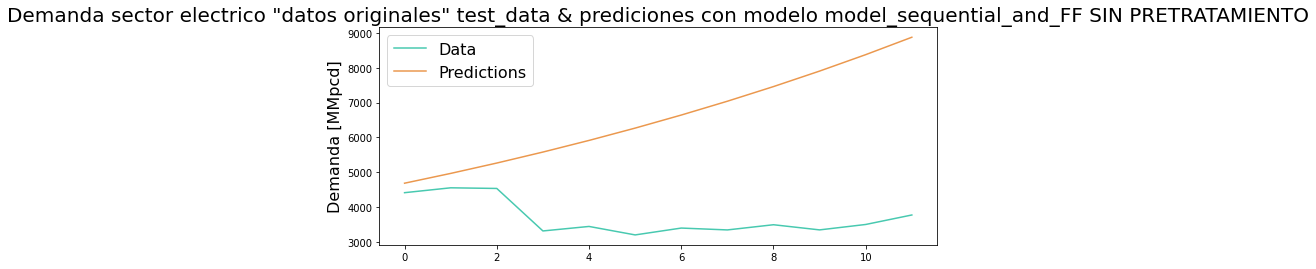

In [49]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, color='#48C9B0')
plt.plot(test_predictions_model_sequential_and_FF , color='#EB984E')
plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Demanda sector electrico "datos originales" test_data & prediciones con modelo model_sequential_and_FF SIN PRETRATAMIENTO', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [50]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_sequential_and_FF_sin_pretratamiento = mean_absolute_percentage_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF )
RMSE_predictions_model_sequential_and_FF_sin_pretratamiento = np.sqrt(mean_squared_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF ))

print('MAPE:', MAPE_predictions_model_sequential_and_FF_sin_pretratamiento)
print('RMSE:', RMSE_predictions_model_sequential_and_FF_sin_pretratamiento)

MAPE: 0.8286653382244844
RMSE: 3310.697183347069
